In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import numpy as np
from scipy.ndimage import zoom,rotate,shift
from matplotlib.image import imsave
import copy
import math
import random
from glob import glob
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs,mode='reflect')

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs ,mode='reflect')

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [2]:
from scipy.ndimage import zoom
def resample(imgs, spacing, new_spacing=[1,1,1]):  # 重采样 ，即把原图的像素间隔统一
    new_shape = []  # 新图大小会变，如  原有4个切片，像素间隔为2.5，重采样后有10个切片，像素间隔为1
    for i in range(3):  # 对每个维度 0，1，2  → z，y，x
        new_zyx = np.round(imgs.shape[i]*spacing[i]/new_spacing[i])  # round为四舍五入（原图尺寸 * 原像素间隔/新像素间隔）
        new_shape.append(new_zyx)  # new_shape集齐新zyx尺寸
    resize_factor = []  # 新图尺寸/原图尺寸   即缩放比例，如  原像素间隔为2.5，新像素间隔为1，放缩比例为1/2.5
    for i in range(3):  # 依次为 0 1 2 → z y x
        resize_zyx = new_shape[i]/imgs.shape[i]  # 放缩比例
        resize_factor.append(resize_zyx)  # 放缩比例 存入 resize_factor ，zoom函数要用
    imgs = zoom(imgs, resize_factor, mode = 'nearest')   # 放缩，边缘使用最近邻，插值默认为三线性插值
    return imgs
    

In [10]:
# 差值改变数组形状，输入为原始图像和目标大小，返回改变大小后的图像
def changeshape(imgs, new_shape=[40,40,40]):  
    #print(new_shape,imgs.shape)
    resize_factor = [a/b for a,b in zip(new_shape,imgs.shape)] # 新图尺寸/原图尺寸，即缩放比例
    imgnew = zoom(imgs, resize_factor, mode = 'nearest') # 放缩，边缘使用最近邻，插值默认为三线性插值
    return imgnew  

### 1、生成train集合（100^3）

In [3]:
import pandas as pd
import numpy as np
datflag_0 = pd.read_csv('datflag641-plus.csv')
datflag_0['subset'] = None
# 输入V1 id
V1_id=list((135,205,207,213,255,346,373,518,584,608,618))
print(len(V1_id))
datflag_0.loc[datflag_0.apply(lambda x: x['ID'] in V1_id, axis=1),'subset'] = 'V1'
print(datflag_0['subset'].value_counts())
datflag_0.loc[:20,]

11
V1    33
Name: subset, dtype: int64


,ID,X,Y,Z,Size.cm.,flag,lung,position,Image.type,Pathology,subset
0,1,180,276,77-94,0.90,grade3,右肺,上叶,纯实性,鳞癌,None
1,2,133,285,80-82,0.30,浸润前病变,右肺,上叶,纯磨玻璃,AAH,None
2,2,172,345,83-85,0.40,浸润前病变,右肺,上叶,纯磨玻璃,AAH,None
3,2,123,259,85-99,1.00,浸润前病变,右肺,上叶,纯磨玻璃,AIS,None
4,2,227,297,97-99,0.30,良性,右肺,上叶,纯磨玻璃,良性,None
5,2,95,243,111-113,0.30,良性,右肺,上叶,纯磨玻璃,良性,None
6,2,159,260,106-109,0.25,良性,右肺,上叶,纯磨玻璃,良性,None
7,2,160,239,117-120,0.40,浸润前病变,右肺,上叶,纯磨玻璃,AAH,None
8,2,130,219,152-157,0.60,良性,右肺,上叶,部分实性,良性,None
9,2,120,288,244-250,0.50,浸润前病变,右肺,下叶,纯磨玻璃,AIS,None


### 2、进行处理

In [4]:
# 首先是V1
datflag=datflag_0.loc[datflag_0['subset']=='V1',]
datflag['index']=datflag.index
len(datflag)

/tmp/ipykernel_1554/3380455142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datflag['index']=datflag.index


33

In [6]:
C_Xname=[]
C_Xname.extend([int(a.split('/course75/RealData/data/org/')[-1].split('.npy')[0]) for a in glob('/course75/RealData/data/org/*.npy')])
print(len(C_Xname))
datflag=datflag.loc[datflag.apply(lambda x: x['index'] not in C_Xname, axis=1),]
print(len(datflag))
datflag

1062
13


,ID,X,Y,Z,Size.cm.,flag,lung,position,Image.type,Pathology,subset,index
243,135,200,217,32-38,0.80,浸润前病变,右肺,上叶,纯磨玻璃,AIS,V1,243
247,135,172,261,14-24,0.90,浸润前病变,右肺,上叶,纯磨玻璃,AAH,V1,247
250,135,336,298,46-56,1.00,浸润前病变,左肺,上叶,纯磨玻璃,AIS,V1,250
373,205,352,354,39-45,0.60,良性,左肺,上叶,纯实性,良性,V1,373
396,207,169,309,24-44,2.00,grade2,右肺,上叶,部分实性,腺癌,V1,396
406,213,465,296,288-295,0.68,良性,左肺,下叶,纯实性,肺内淋巴结,V1,406
472,255,170,290,16-23,2.60,grade1,右肺,上叶,部分实性,腺癌,V1,472
611,346,296,299,50-55,0.50,良性,左肺,上叶,纯实性,良性,V1,611
652,373,321,384,176-216,3.20,grade2,左肺,下叶,纯实性,腺癌,V1,652
904,518,199,293,36-53,0.95,浸润前病变,右肺,上叶,纯磨玻璃,AIS,V1,904


In [11]:
from matplotlib.image import imsave
import copy
# 读入CT数据
CT_path = "/course75/RealData/CT/"
for i in datflag['ID'].unique(): # 只读有标记的CT
    print('第'+str(i)+'位患者CT：')
    file_path = CT_path+ str(i)
    img_array = imageio.volread(file_path, 'DICOM') # 直接读取文件夹中的所有dicom文件为vol，返回的是HU值
    # 获取meta数据，像素间隔
    spacing = img_array.meta['sampling'] # 注意是zyx顺序
    num_z, height, width = img_array.shape    
    print('CT大小：',img_array.shape)
    print(spacing)
    # 提取结节位置
    df_node = datflag[datflag['ID'] == i].reset_index()
    center,diam = [],[]
    for j in range(df_node.shape[0]): # 可能一位患者有多个结节，df_node.shape[0]结节数
        node_x = df_node["X"][j]
        node_y = df_node["Y"][j]
        node_z = [int(df_node['Z'][j].split('-')[0]),int(df_node['Z'][j].split('-')[1])]
        diam.append(df_node["Size.cm."][j]*10)
        center.append([node_x, node_y, node_z]) # center是xyz顺序
    
    lung_mask = img_array
    
    # 对提取出的肺部设置WL，归一化
    max_num = 400  # 阈值最高
    min_num = -1400  # 阈值最低
    new_img = (lung_mask - min_num) / (max_num - min_num)  # 归一化
    new_img[new_img > 1] = 1.  # 高于1的归1，float格式
    new_img[new_img < 0] = 0.  # 低于0的归0，float格式
    img = new_img - 0.25  # 去均值
    newspacing = 0.625  
    datmini = datflag[datflag['ID'] == i]
    # 按照像素间隔，这套CT需要截取出来进行resample的图像大小
    SIZE=100
    snum = [math.ceil(SIZE*newspacing/spacing[0]/2),math.ceil(SIZE*newspacing/spacing[1]/2),math.ceil(SIZE*newspacing/spacing[2]/2)]
    for j in datmini.index: #遍历这套CT中的结节，存所有结节   
        # 存储大小为SIZE
        z = round((int(datmini['Z'][j].split('-')[0])+int(datmini['Z'][j].split('-')[1]))/2)
        x = datmini['X'][j]
        y = datmini['Y'][j]
        zmin = max(0,z-snum[0])
        zmax = min(img.shape[0],z+snum[0])
        zdia = min((z-zmin),(zmax-z))
        zmin = z-zdia
        zmax = z+zdia
        ymin = max(0,y-snum[1])
        ymax = min(img.shape[1],y+snum[1])
        ydia = min((y-ymin),(ymax-y))
        ymin = y-ydia
        ymax = y+ydia
        xmin = max(0,x-snum[2])
        xmax = min(img.shape[2],x+snum[2])
        xdia = min((x-xmin),(xmax-x))
        xmin = x-xdia
        xmax = x+xdia
        imgsmall = img[zmin:zmax,ymin:ymax,xmin:xmax] # 以结节为中心，截取的小块
        imgresample = resample(imgsmall, spacing, new_spacing=[newspacing,newspacing,newspacing])
        zmin = max(0,round(imgresample.shape[0]/2)-int(SIZE/2))
        zmax = min(imgresample.shape[0],round(imgresample.shape[0]/2)+int(SIZE/2))
        ymin = max(0,round(imgresample.shape[1]/2)-int(SIZE/2))
        ymax = min(imgresample.shape[1],round(imgresample.shape[1]/2)+int(SIZE/2))
        xmin = max(0,round(imgresample.shape[2]/2)-int(SIZE/2))
        xmax = min(imgresample.shape[2],round(imgresample.shape[2]/2)+int(SIZE/2))
        imgsize = imgresample[zmin:zmax,ymin:ymax,xmin:xmax]
        if imgsize.shape==(SIZE,SIZE,SIZE):
            savenode = imgsize
        else:
            savenode = changeshape(imgsize,new_shape=[SIZE,SIZE,SIZE])
        print('保存大小：',savenode.shape)            
        np.save('Reshaped/org/'+str(j)+'.npy',savenode)# 命名是按照dataframe中的结节序号

第135位患者CT：
Reading DICOM (examining files): 1/475 files (0.231/475 files (6.5%62/475 files (13.192/475 files (19.4129/475 files (27.2%167/475 files (35.2%199/475 files (41.9%239/475 files (50.3%283/475 files (59.6%308/475 files (64.8%329/475 files (69.3%361/475 files (76.0%389/475 files (81.9%411/475 files (86.5%429/475 files (90.3%447/475 files (94.1%463/475 files (97.5%475/475 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 19/475  (4.042/475  (8.862/475  (13.1%80/475  (16.8%100/475  (21.1124/475  (26.1146/475  (30.7172/475  (36.2194/475  (40.8216/475  (45.5234/475  (49.3256/475  (53.9277/475  (58.3298/475  (62.7315/475  (66.3334/475  (70.3348/475  (73.3366/475  (77.1381/475  (80.2394/475  (82.9407/475  (85.7420/475  (88.4433/475  (91.2445/475  (93.7458/475  (96.4471/475  (99.2475/475  (100.0%)
CT大小： (475, 512, 512)
(0.6, 0.666015625, 0.666015625)
保存大小： (100, 100, 100)
保存大小： (100, 100, 100)
保存大小： (100, 100, 100)
第205位患者CT：
Reading DICOM (examining files): 1/449

Reading DICOM (loading data): 15/493  (3.032/493  (6.545/493  (9.157/493  (11.6%72/493  (14.6%87/493  (17.6%100/493  (20.3115/493  (23.3129/493  (26.2142/493  (28.8156/493  (31.6170/493  (34.5184/493  (37.3198/493  (40.2210/493  (42.6224/493  (45.4236/493  (47.9247/493  (50.1261/493  (52.9272/493  (55.2286/493  (58.0298/493  (60.4311/493  (63.1325/493  (65.9336/493  (68.2346/493  (70.2356/493  (72.2366/493  (74.2377/493  (76.5388/493  (78.7397/493  (80.5407/493  (82.6412/493  (83.6415/493  (84.2418/493  (84.8428/493  (86.8438/493  (88.8448/493  (90.9458/493  (92.9466/493  (94.5475/493  (96.3484/493  (98.2493/493  (100.0%)
CT大小： (493, 512, 512)
(0.6000000000000018, 0.712890625, 0.712890625)
保存大小： (100, 100, 100)
第373位患者CT：
Reading DICOM (examining files): 1/225 files (0.410/225 files (4.4%20/225 files (8.9%30/225 files (13.338/225 files (16.950/225 files (22.260/225 files (26.771/225 files (31.681/225 files (36.091/225 files (40.4103/225 files (45.8%113/225 files (50.2%123/225 files (54

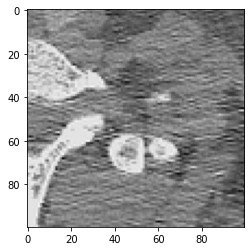

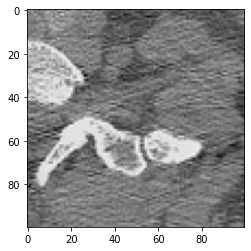

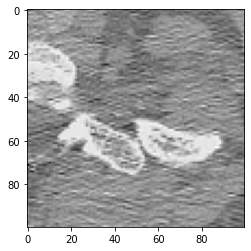

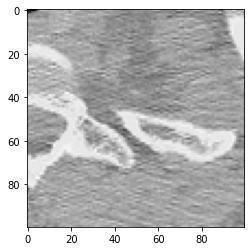

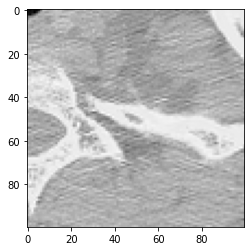

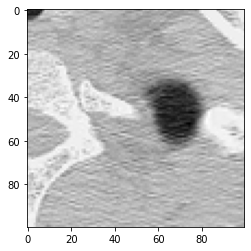

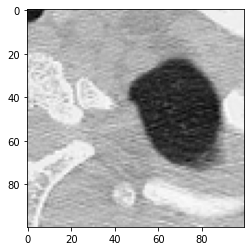

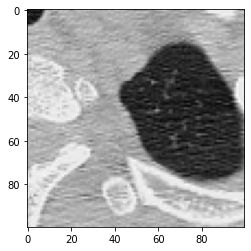

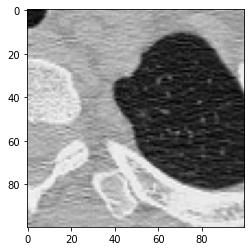

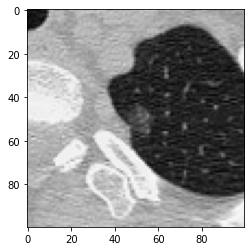

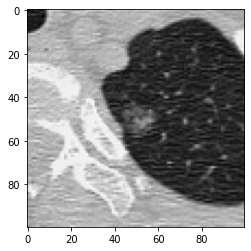

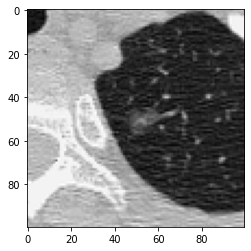

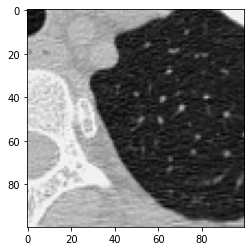

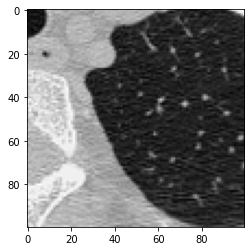

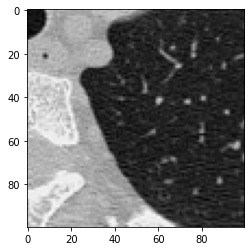

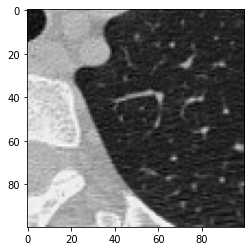

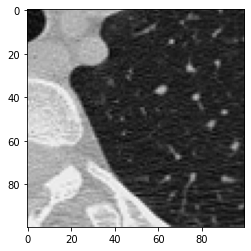

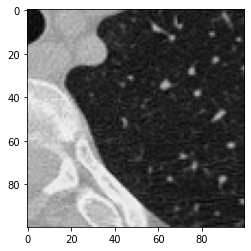

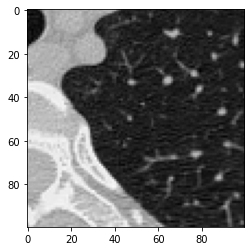

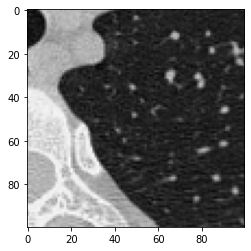

In [17]:
# 看看效果
save_node=np.load('Reshaped/org/1000.npy')
for i in range(0,100,5):
    plt.imshow(save_node[i,:,:],cmap='gray')#
    plt.show()

### 3、应用数据增强

In [19]:
import numpy as np
from scipy.ndimage import zoom,rotate,shift
import random
import copy
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs,mode='reflect')

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs ,mode='reflect')

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

全部处理

In [20]:
# 读入V1数据文件名
node_path = 'Reshaped/org/' # 需修改
save_path = 'Reshaped/agm/' # 需修改
V1Xname = []
V1Y = []
V1Xname.extend([a.split('Reshaped/org/')[-1] for a in glob(node_path+'/'+'*.npy')])
#for idx,name in enumerate(['良性','浸润前病变','其他恶性癌','grade1','grade2','grade3']):
#    V1Xname.extend([a.split('node100resample-636/')[-1] for a in glob(node_path+'V1/'+name+'/'+'*.npy')])

In [21]:
print(len(V1Xname))# 数据增强前长度
V1Xname

13


['243.npy',
 '250.npy',
 '1000.npy',
 '396.npy',
 '652.npy',
 '247.npy',
 '373.npy',
 '472.npy',
 '904.npy',
 '1031.npy',
 '611.npy',
 '406.npy',
 '1049.npy']

In [22]:
for i in range(len(V1Xname)):
    print(i,V1Xname[i])
    path = node_path+V1Xname[i]
    savepath = save_path+V1Xname[i]
    img = np.load(path) # 读取上面存好的60x60x60体积块
    # 轴对换：生成6张图片
    img1 = img.transpose(1,2,0)
    img2 = img.transpose(2,0,1)
    img3 = img.transpose(0,2,1)
    img4 = img.transpose(1,0,2) 
    img5 = img.transpose(2,1,0)
    np.save(savepath.split('.')[0]+'_trans_0.npy',img)
    np.save(savepath.split('.')[0]+'_trans_1.npy',img1)
    np.save(savepath.split('.')[0]+'_trans_2.npy',img2)
    np.save(savepath.split('.')[0]+'_trans_3.npy',img3)
    np.save(savepath.split('.')[0]+'_trans_4.npy',img4)
    np.save(savepath.split('.')[0]+'_trans_5.npy',img5)
    # 旋转：固定z轴，每36度进行旋转，生成9张图片
    for j in range(1,10):
        image_rotated = rotate(img, j*36,axes=(1,2),mode='reflect', reshape=False) # 第一维是z，在后两维上进行旋转
        np.save(savepath.split('.')[0]+'_rotate_'+str(j)+'.npy',image_rotated)
    # 平移：-10到10之间随机平移，生成1张图片
    image_shift=copy.copy(img)
    r_range1=random.uniform(-10,10)
    r_range2=random.uniform(-10,10)
    for h in range(img.shape[0]):
        image_shift[h]=shift(img[h], shift=(r_range1, r_range2) ,mode='reflect')
    np.save(savepath.split('.')[0]+'_sft.npy',image_shift)
    # 放缩：放大至1.5倍，生成1张图片
    # image_zoom=copy.copy(img)
    # for k in range(60):
    #     image_zoom[k]=clipped_zoom(img[k], 1.5)
    # np.save(savepath.split('.')[0]+'_zoom.npy',image_zoom)

0 243.npy
1 250.npy
2 1000.npy
3 396.npy
4 652.npy
5 247.npy
6 373.npy
7 472.npy
8 904.npy
9 1031.npy
10 611.npy
11 406.npy
12 1049.npy


对直径小于等于1cm的进行放大

In [24]:
# 读入训练数据文件名
node_path = 'Reshaped/org/' # 需修改
save_path = 'Reshaped/agm/' # 需修改
V1Xname = []
V1Y = []
zoomed_index=[]
V1Xname.extend([a.split('Reshaped/org/')[-1] for a in glob(node_path+'/'+'*.npy')])
print(len(V1Xname))
for i in range(len(V1Xname)):
    print(i,V1Xname[i])
    c_index=V1Xname[i].split('/')[-1]
    c_index=c_index.split('.')[0]
    if datflag_0.loc[int(c_index),'Size.cm.']<=1:
        zoomed_index.append(c_index)
        path = node_path+V1Xname[i]
        savepath = save_path+V1Xname[i]
        img = np.load(path)
        image_zoom=copy.copy(img)
        for k in range(img.shape[0]):
            image_zoom[k]=clipped_zoom(img[k], 1.5)
        np.save(savepath.split('.')[0]+'_zoom.npy',image_zoom)

13
0 243.npy
1 250.npy
2 1000.npy
3 396.npy
4 652.npy
5 247.npy
6 373.npy
7 472.npy
8 904.npy
9 1031.npy
10 611.npy
11 406.npy
12 1049.npy


生成结节展示

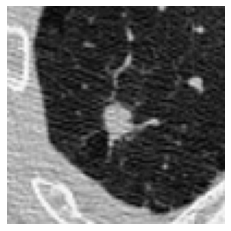

In [37]:
# 原图
plt.figure(figsize=(4,4))
save_node=np.load('/course75/RealData/data/org/0.npy')
plt.imshow(save_node[49,:,:],cmap='gray')#
plt.axis('off')
#plt.savefig('原图.png', bbox_inches='tight')
plt.show()

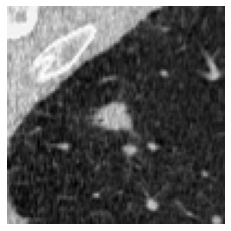

In [38]:
# 轴对换：生成6张图片
plt.figure(figsize=(4,4))
save_node=np.load('/course75/RealData/data/agm/0_trans_1.npy')
plt.imshow(save_node[49,:,:],cmap='gray')
plt.axis('off')
plt.show()

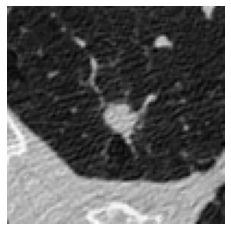

In [39]:
# 每36度进行旋转，生成9张图片
plt.figure(figsize=(4,4))
save_node=np.load('/course75/RealData/data/agm/0_rotate_1.npy')
plt.imshow(save_node[49,:,:],cmap='gray')
plt.axis('off')
plt.show()

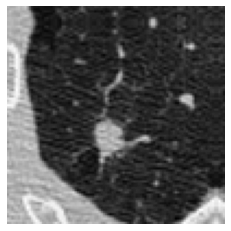

In [40]:
# 平移
plt.figure(figsize=(4,4))
save_node=np.load('/course75/RealData/data/agm/0_sft.npy')
plt.imshow(save_node[49,:,:],cmap='gray')
plt.axis('off')
plt.show()

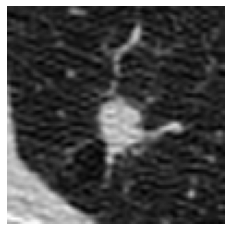

In [41]:
# zoom
plt.figure(figsize=(4,4))
save_node=np.load('/course75/RealData/data/agm/0_zoom.npy')
plt.imshow(save_node[49,:,:],cmap='gray')
plt.axis('off')
plt.show()